In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
import scipy.stats as stats

sns.set_theme(style="whitegrid")
sns.set_context('paper')

pd.set_option('display.max_rows', 500)

In [4]:
# timestamp,program,flag,return_code,execution_time,pkg_energy,dram_energy,user_time,sys_time,total_time,cpu_percent,avg_text,avg_data,peak_rss,inputs,outputs,minor_pagefaults,major_pagefaults,swaps,alloc_mem,reclaimed_mem,rts_mem,total_gcs,minor_gcs,major_gcs,avg_mem,max_mem,n_samples,init_cpu,init_sys,mut_cpu,mut_sys,total_gc_cpu,total_gc_sys,minor_gc_cpu,minor_gc_sys,major_gc_cpu,major_gc_sys,balance
data_files = [
    '../data/results.csv',
    '../data/results_2.csv'
]

df = pd.concat(map(lambda file: pd.read_csv(file), data_files))
df['total_energy'] = df['pkg_energy'] + df['dram_energy']
display(df.head(5))

progs = df['program'].unique()
print(f"Programs ({len(progs)}): {progs}")
flags = df['flag'].unique()[1:]
print(f"Flags ({len(flags)}): {flags}")

timestamp  program flag  return_code  execution_time  pkg_energy  \
0  1683221035  circsim  -O2            0      245286.912   1602169.0   
1  1683221036  circsim  -O2            0      237353.362   1583614.0   
2  1683221042  circsim  -O2            0      238780.570   1529782.0   
3  1683221054  circsim  -O2            0      241376.445   1528561.0   
4  1683221066  circsim  -O2            0      244602.692   1515926.0   

   dram_energy  user_time  sys_time  total_time  ...  init_sys  mut_cpu  \
0      52734.0       0.21      0.00        0.22  ...       0.0    0.118   
1      52795.0       0.21      0.00        0.21  ...       0.0    0.118   
2      48157.0       0.19      0.02        0.21  ...       0.0    0.117   
3      48401.0       0.21      0.00        0.21  ...       0.0    0.119   
4      49377.0       0.20      0.02        0.22  ...       0.0    0.120   

   mut_sys  total_gc_cpu  total_gc_sys  minor_gc_cpu  minor_gc_sys  \
0    0.118         0.101         0.101         0.093         0.093   
1    0.118         0.097         0.098         0.089         0.090   
2    0.116         0.097         0.098         0.090         0.090   
3    0.118         0.098         0.099         0.090         0.091   
4    0.120         0.100         0.100         0.092         0.092   

   major_gc_cpu  major_gc_sys  balance  
0         0.008         0.008        1  
1         0.008         0.008        1  
2         0.007         0.007        1  
3         0.008         0.008        1  
4         0.008         0.008        1  

[5 rows x 39 columns]

Programs (14): ['circsim' 'hash' 'bernouilli' 'integrate' 'coins' 'queens' 'anna' 'fluid'
 'binary-trees' 'pidigits' 'callback001' 'chan' 'power' 'treejoin']
Flags (24): ['-fno-case-merge' '-fno-case-folding' '-fno-call-arity'
 '-fno-exitification' '-fno-cmm-elim-common-blocks' '-fno-cmm-sink'
 '-fno-block-layout-cfg' '-fno-cpr-anal' '-fno-cse' '-fno-stg-cse'
 '-fno-dmd-tx-dict-sel' '-fno-do-eta-reduction'
 '-fno-do-lambda-eta-expansion' '-fno-float-in' '-fno-full-laziness'
 '-fno-ignore-asserts' '-fno-loopification' '-fno-specialise'
 '-fno-solve-constant-dicts' '-fno-stg-lift-lams' '-fno-strictness'
 '-fno-unbox-small-strict-fields' '-fno-spec-constr' '-fno-liberate-case']


## Correlation between `*_energy` and `execution_time`

In [10]:
x, y = 'total_energy', 'execution_time'

fig = px.scatter(df, x=x, y=y, color='program')
fig.show()

corr, pvalue = stats.spearmanr(df[x], df[y])
print(f'{corr:.4f} (p = {pvalue:.4f})')

0.9886 (p = 0.0000)


In [17]:
x, y = 'pkg_energy', 'execution_time'

fig = px.scatter(df, x=x, y=y, color='program')
fig.show()

corr, pvalue = stats.spearmanr(df[x], df[y])
print(f'{corr:.4f} (p = {pvalue:.4f})')

0.9885 (p = 0.0000)


In [16]:
x, y = 'dram_energy', 'execution_time'

fig = px.scatter(df, x=x, y=y, color='program')
fig.show()

corr, pvalue = stats.spearmanr(df[x], df[y])
print(f'{corr:.4f} (p = {pvalue:.4f})')

0.9538 (p = 0.0000)


___

## Correlation between `pkg_energy` and `dram_energy`

In [19]:
x, y = 'pkg_energy', 'dram_energy'

fig = px.scatter(df, x=x, y=y, color='program')
fig.show()

corr, pvalue = stats.spearmanr(df[x], df[y])
print(f'{corr:.4f} (p = {pvalue:.4f})')

0.9503 (p = 0.0000)


In [5]:
def calculate_increase(data, column):
    new_dataframe = []

    for prog in progs:
        base_mean = data[(data['flag'] == '-O2') & (data['program'] == prog)][column].mean()
        
        for flag in flags:
            flag_mean = data[(data['flag'] == flag) & (data['program'] == prog)][column].mean()
            increase = ((flag_mean - base_mean) / base_mean) * 100
            new_dataframe.append([prog, flag, base_mean, flag_mean, increase])

    return pd.DataFrame(new_dataframe, columns=['program', 'flag', 'base_mean', 'flag_mean', 'increase'])

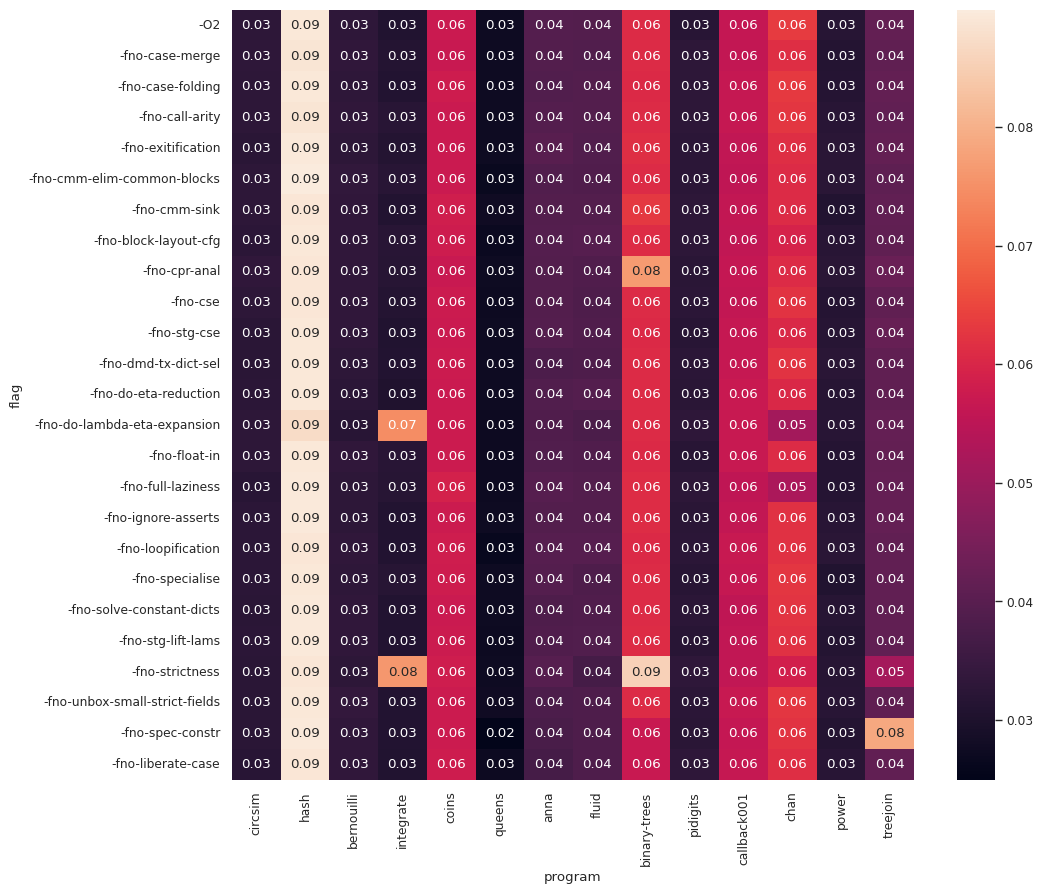

In [7]:
new_df = calculate_increase(df, 'dram_pkg_ratio')
plt.figure(figsize=(11,10))
ax = sns.heatmap(
    data = df.pivot_table(index='flag', columns='program', values='dram_pkg_ratio', sort=False),
    annot = df.pivot_table(index='flag', columns='program', values='dram_pkg_ratio', sort=False),
    fmt='.2f'
)
plt.show()

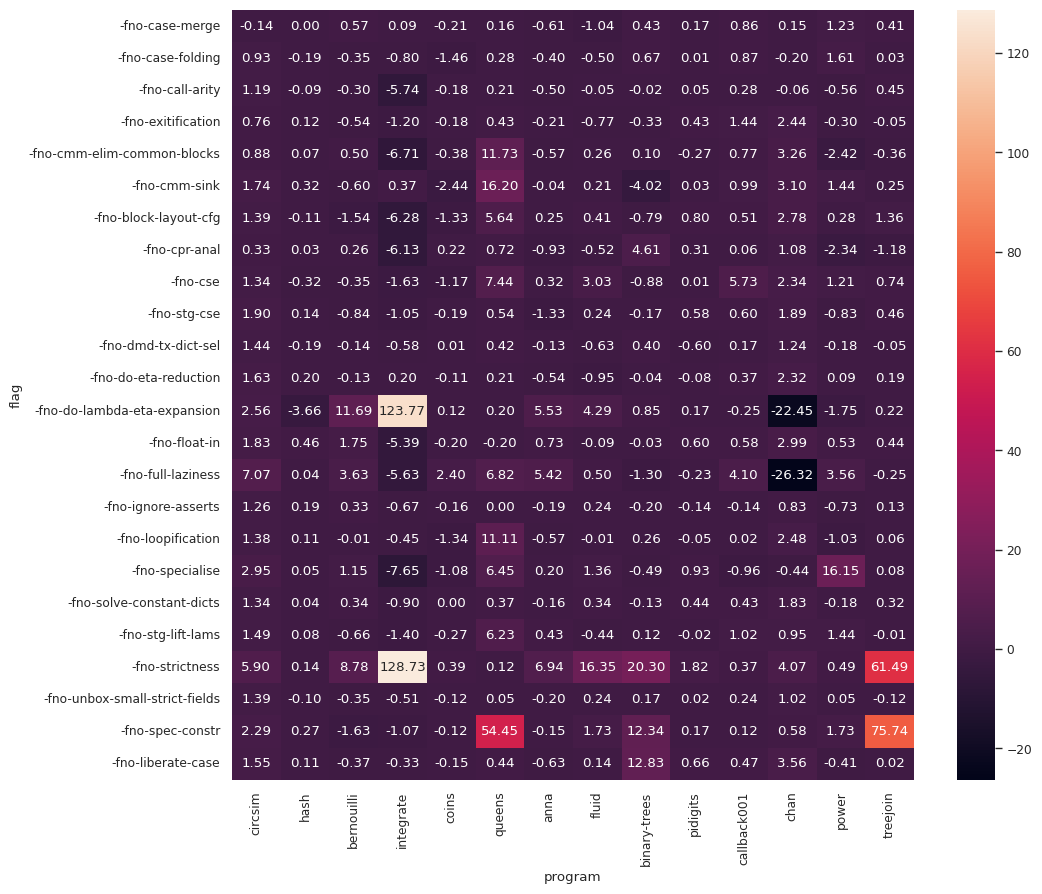

In [89]:
new_df = calculate_increase(df, 'pkg_energy')
plt.figure(figsize=(11,10))
ax = sns.heatmap(
    data = new_df.pivot_table(index='flag', columns='program', values='increase', sort=False),
    annot = new_df.pivot_table(index='flag', columns='program', values='increase', sort=False),
    fmt='.2f'
)
plt.show()

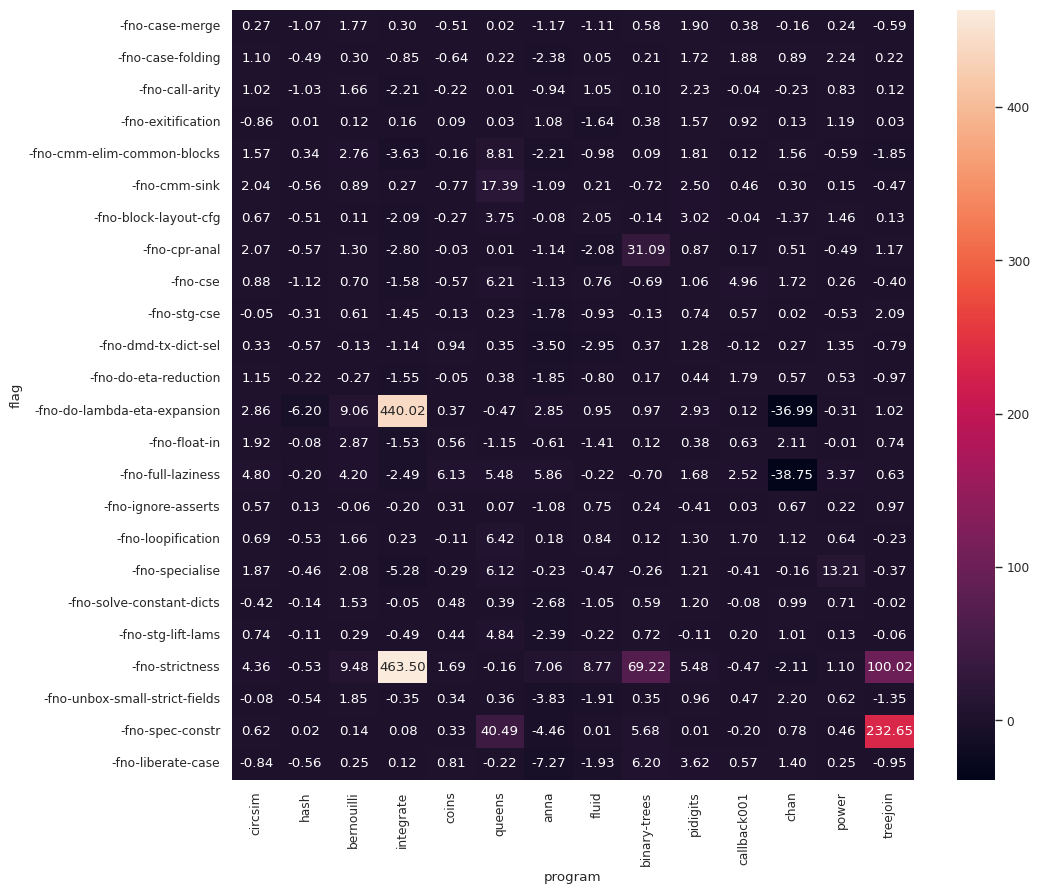

In [8]:
new_df = calculate_increase(df, 'dram_energy')
plt.figure(figsize=(11,10))
ax = sns.heatmap(
    data = new_df.pivot_table(index='flag', columns='program', values='increase', sort=False),
    annot = new_df.pivot_table(index='flag', columns='program', values='increase', sort=False),
    fmt='.2f'
)
plt.show()

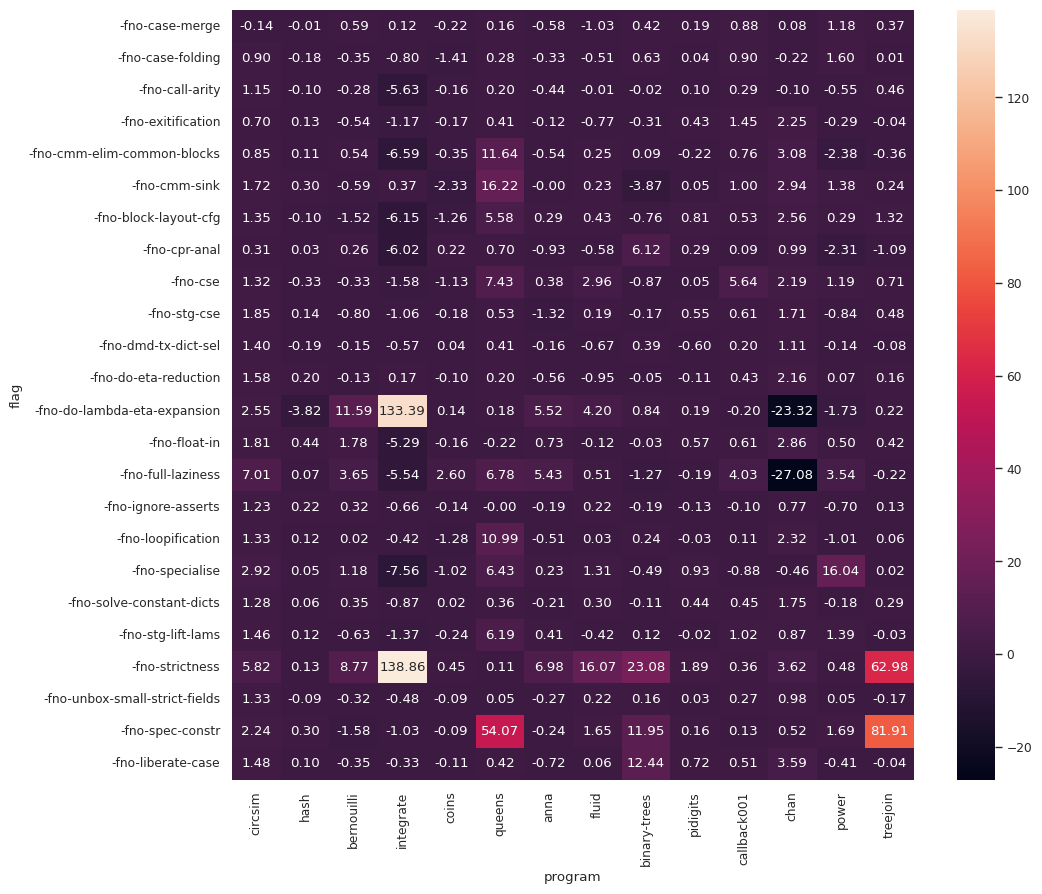

In [14]:
new_df = calculate_increase(df, 'total_energy')
plt.figure(figsize=(11,10))
ax = sns.heatmap(
    data = new_df.pivot_table(index='flag', columns='program', values='increase', sort=False),
    annot = new_df.pivot_table(index='flag', columns='program', values='increase', sort=False),
    fmt='.2f'
)
plt.show()

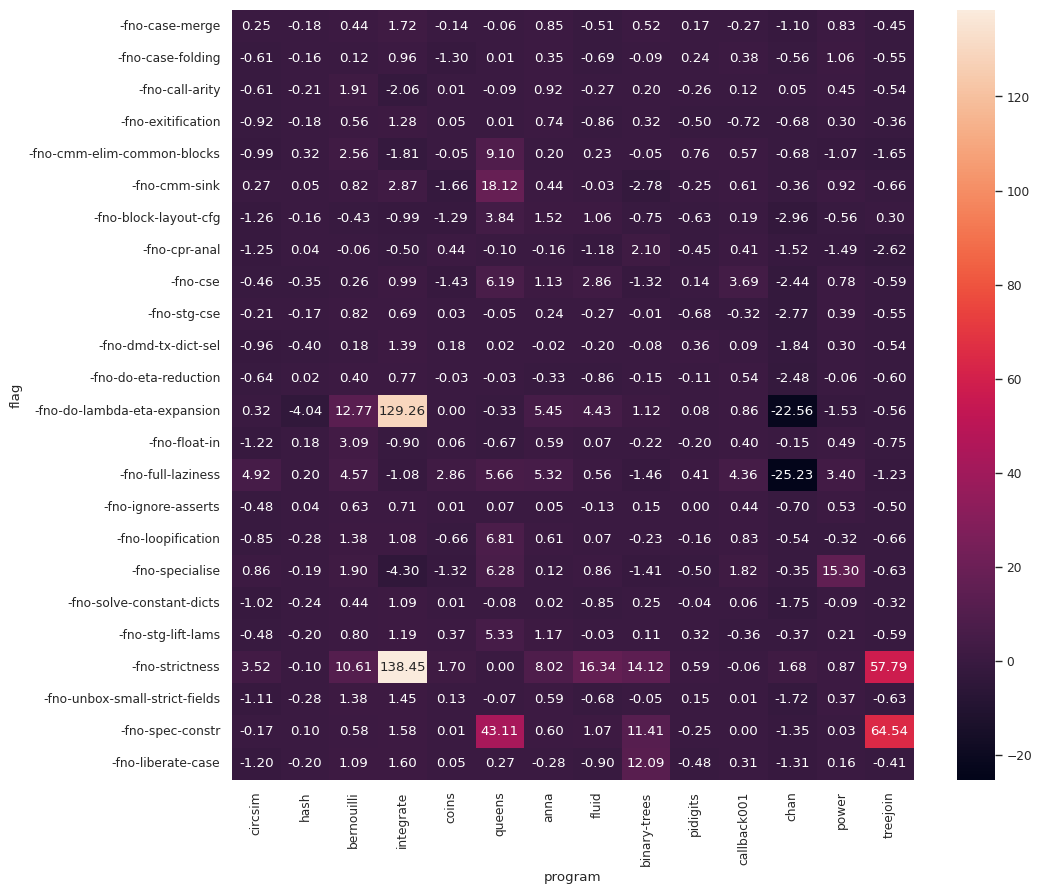

In [118]:
new_df = calculate_increase(df, 'execution_time')
plt.figure(figsize=(11,10))
ax = sns.heatmap(
    data = new_df.pivot_table(index='flag', columns='program', values='increase', sort=False),
    annot = new_df.pivot_table(index='flag', columns='program', values='increase', sort=False),
    fmt='.2f'
)
plt.show()

In [18]:
fig = px.scatter(df, x='pkg_energy', y='dram_energy', color='program', symbol='flag')
fig.show()

The number of garbage collector passes seems to be consistent within the same program. It varies with some flags, but so far it does not seem to be too much. This makes sense as the program always takes in the same data as input.

#### Remarks on pkg_energy
We see again one big gap in the energy measurements between 0.4\*1e7 and 1.0\*1e7.

